# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

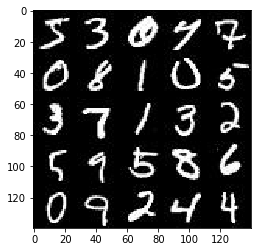

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

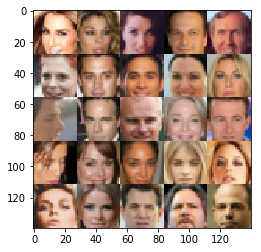

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    z_data = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learn_rate = tf.placeholder(tf.float32, name="lr")
    return r_inputs, z_data, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    n_units = 4 * 4 * 256
    alpha = 0.2
    stddev = 0.05
    keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1, n_units))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    num_units = 7*7*512
    stddev = 0.05
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, num_units)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                       activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                       activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                           activation=None)
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    gen_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(gen_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_real, labels = tf.ones_like(disc_output_real) * (1 - smooth) )
    )
    
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_fake, labels = tf.zeros_like(disc_output_fake) )
    )
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_fake, labels = tf.ones_like(disc_output_fake) )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        return disc_train_opt, gen_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    steps = 0
    total_steps = epoch_count * batch_size
    losses = []
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate} )
                _ = sess.run(gen_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate} )
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


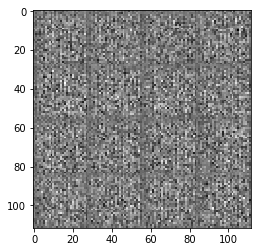

Epoch 1/2... Discriminator Loss: 0.8200... Generator Loss: 1.3260
Epoch 1/2... Discriminator Loss: 2.0732... Generator Loss: 0.2792
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 1.5175
Epoch 1/2... Discriminator Loss: 1.6400... Generator Loss: 3.5948
Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 1.9588
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 1.0232
Epoch 1/2... Discriminator Loss: 1.3596... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.5592... Generator Loss: 0.6711
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 1.2865
Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 0.9338


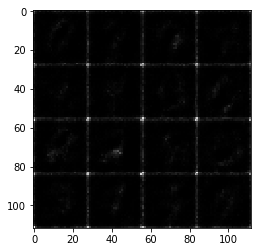

Epoch 1/2... Discriminator Loss: 1.7669... Generator Loss: 0.3893
Epoch 1/2... Discriminator Loss: 1.4668... Generator Loss: 1.6453
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.9577
Epoch 1/2... Discriminator Loss: 1.5073... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 1.1119
Epoch 1/2... Discriminator Loss: 0.9511... Generator Loss: 1.6827
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 1.4524
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.5362


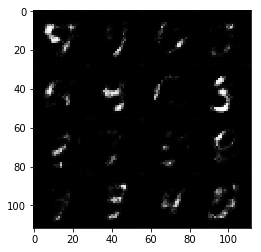

Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 0.9133
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 2.0595
Epoch 1/2... Discriminator Loss: 0.8181... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 1.7448
Epoch 1/2... Discriminator Loss: 0.8594... Generator Loss: 1.3852
Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 0.8440
Epoch 1/2... Discriminator Loss: 2.0595... Generator Loss: 0.2843
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 2.0537
Epoch 1/2... Discriminator Loss: 0.8494... Generator Loss: 1.5778


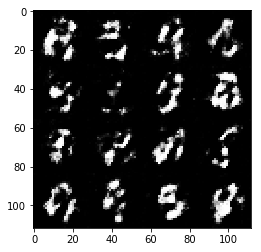

Epoch 1/2... Discriminator Loss: 1.9411... Generator Loss: 0.3465
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 0.8740
Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 1.5056
Epoch 1/2... Discriminator Loss: 0.9009... Generator Loss: 1.1358
Epoch 1/2... Discriminator Loss: 0.9557... Generator Loss: 2.9052
Epoch 1/2... Discriminator Loss: 0.7490... Generator Loss: 1.4541
Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 2.9551
Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 2.0429
Epoch 1/2... Discriminator Loss: 0.8586... Generator Loss: 2.0521
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 1.0106


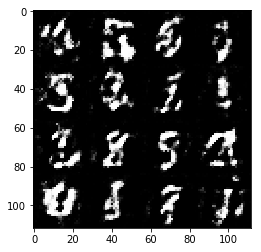

Epoch 1/2... Discriminator Loss: 0.8586... Generator Loss: 1.3429
Epoch 1/2... Discriminator Loss: 0.6024... Generator Loss: 1.9716
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 2.0013
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 2.6929
Epoch 1/2... Discriminator Loss: 0.8525... Generator Loss: 1.1162
Epoch 1/2... Discriminator Loss: 1.1555... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 1.1077
Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 1.1715
Epoch 1/2... Discriminator Loss: 0.7359... Generator Loss: 1.3561
Epoch 1/2... Discriminator Loss: 0.7126... Generator Loss: 1.7624


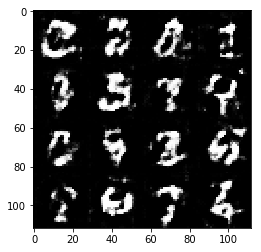

Epoch 1/2... Discriminator Loss: 0.6690... Generator Loss: 1.5275
Epoch 1/2... Discriminator Loss: 0.6400... Generator Loss: 2.0722
Epoch 1/2... Discriminator Loss: 0.8623... Generator Loss: 1.2348
Epoch 1/2... Discriminator Loss: 1.5028... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 1.3791
Epoch 1/2... Discriminator Loss: 0.6159... Generator Loss: 2.1327
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 1.7380
Epoch 1/2... Discriminator Loss: 0.8365... Generator Loss: 1.6706
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.5621
Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 1.4521


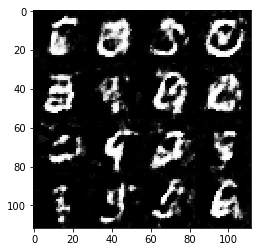

Epoch 1/2... Discriminator Loss: 0.9182... Generator Loss: 1.2279
Epoch 1/2... Discriminator Loss: 0.7952... Generator Loss: 1.4593
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.8061
Epoch 1/2... Discriminator Loss: 1.5731... Generator Loss: 0.5537
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 1.2391
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.4992
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 1.0786
Epoch 1/2... Discriminator Loss: 0.6587... Generator Loss: 2.2681
Epoch 1/2... Discriminator Loss: 1.5095... Generator Loss: 3.9010


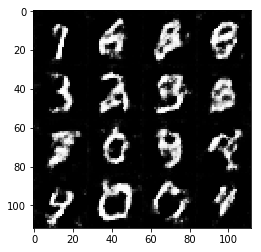

Epoch 1/2... Discriminator Loss: 1.7168... Generator Loss: 2.8959
Epoch 1/2... Discriminator Loss: 0.8146... Generator Loss: 1.4074
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 2.6486
Epoch 1/2... Discriminator Loss: 1.7039... Generator Loss: 0.4792
Epoch 1/2... Discriminator Loss: 1.7033... Generator Loss: 0.3436
Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 2.2338
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 1.2096
Epoch 1/2... Discriminator Loss: 1.4033... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.5936... Generator Loss: 0.5075
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 0.8225


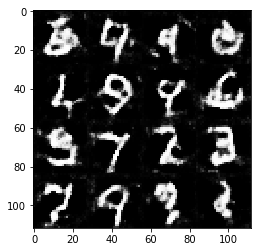

Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 1.2947
Epoch 1/2... Discriminator Loss: 1.4336... Generator Loss: 0.4998
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 1.4583... Generator Loss: 0.6331
Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 1.0240
Epoch 1/2... Discriminator Loss: 0.8476... Generator Loss: 1.2984
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 1.9707
Epoch 1/2... Discriminator Loss: 1.0622... Generator Loss: 0.9813
Epoch 1/2... Discriminator Loss: 1.7973... Generator Loss: 0.3513
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.6553


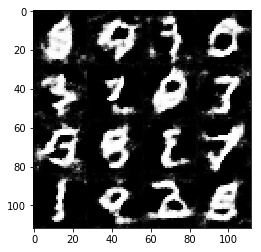

Epoch 1/2... Discriminator Loss: 1.7085... Generator Loss: 0.4592
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 2.0586
Epoch 1/2... Discriminator Loss: 1.2253... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.1886... Generator Loss: 1.1343
Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 1.0948
Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.2464
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 1.9495
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 1.3175
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 0.7538


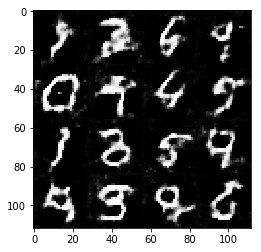

Epoch 1/2... Discriminator Loss: 0.6816... Generator Loss: 1.6798
Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 0.7894
Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 2.0955
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.9678
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 0.9769
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 1.3885
Epoch 1/2... Discriminator Loss: 1.0550... Generator Loss: 1.0558
Epoch 1/2... Discriminator Loss: 0.8462... Generator Loss: 1.1581
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.7780
Epoch 1/2... Discriminator Loss: 1.4606... Generator Loss: 0.4546


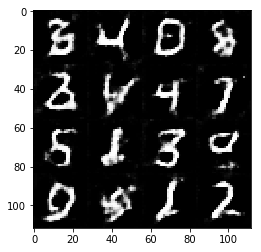

Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 0.6834
Epoch 1/2... Discriminator Loss: 1.1050... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 0.9861... Generator Loss: 1.1430
Epoch 1/2... Discriminator Loss: 1.6336... Generator Loss: 0.3932
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 0.9962
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 1.4215
Epoch 1/2... Discriminator Loss: 0.8505... Generator Loss: 1.2155
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 1.7806
Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 1.3515


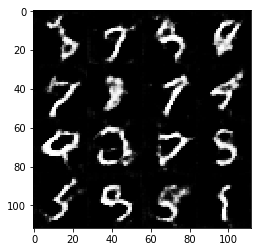

Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 1.0142
Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 0.8419
Epoch 1/2... Discriminator Loss: 1.2286... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.3034... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 0.8011... Generator Loss: 1.4126
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 0.7920
Epoch 1/2... Discriminator Loss: 1.0580... Generator Loss: 1.3515
Epoch 1/2... Discriminator Loss: 0.8029... Generator Loss: 1.0849
Epoch 1/2... Discriminator Loss: 1.5547... Generator Loss: 0.5601


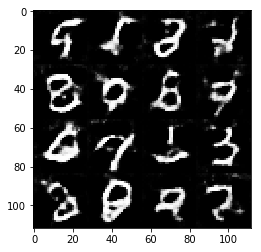

Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.6531
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 1.0319
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 1.0782
Epoch 1/2... Discriminator Loss: 0.7299... Generator Loss: 1.7152
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 2.4159
Epoch 1/2... Discriminator Loss: 1.4669... Generator Loss: 0.5674
Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 0.9852
Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 1.0776
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 0.9913


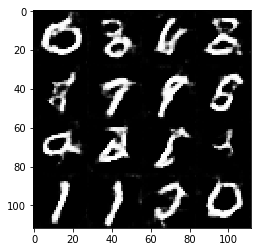

Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 1.7659
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 1.1017
Epoch 1/2... Discriminator Loss: 0.9750... Generator Loss: 1.0110
Epoch 1/2... Discriminator Loss: 0.8094... Generator Loss: 1.5348
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 1.3922
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 1.7541
Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 1.2053
Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 1.0896
Epoch 1/2... Discriminator Loss: 0.6662... Generator Loss: 1.7651
Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 1.1257


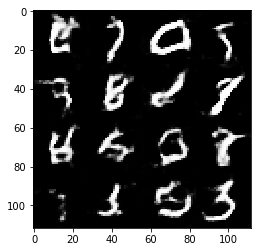

Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 1.5082
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.2485
Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 0.9321
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 2.3642
Epoch 1/2... Discriminator Loss: 0.7232... Generator Loss: 1.5790
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 1.1438
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 0.8082
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.5849
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.6583
Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 1.8477


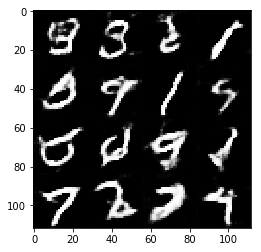

Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 0.5929
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 1.6942
Epoch 1/2... Discriminator Loss: 0.9655... Generator Loss: 1.0185
Epoch 1/2... Discriminator Loss: 0.8789... Generator Loss: 1.1598
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 0.9857
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.6026
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.8567... Generator Loss: 0.3884


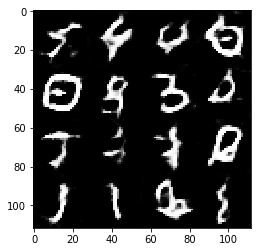

Epoch 1/2... Discriminator Loss: 0.8066... Generator Loss: 1.3348
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 1.1947
Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 1.4939
Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 1.1918
Epoch 1/2... Discriminator Loss: 1.1938... Generator Loss: 0.6740
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 1.5655
Epoch 1/2... Discriminator Loss: 0.9034... Generator Loss: 1.2196
Epoch 1/2... Discriminator Loss: 0.8734... Generator Loss: 1.0091
Epoch 1/2... Discriminator Loss: 0.8449... Generator Loss: 1.2906


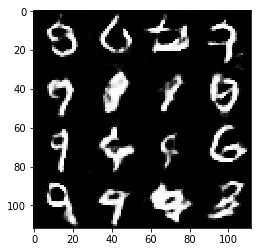

Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 1.7141
Epoch 1/2... Discriminator Loss: 0.8837... Generator Loss: 1.2424
Epoch 1/2... Discriminator Loss: 0.7260... Generator Loss: 1.5582
Epoch 1/2... Discriminator Loss: 0.9592... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 3.3812... Generator Loss: 0.1083
Epoch 1/2... Discriminator Loss: 0.7787... Generator Loss: 1.1996
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 0.9887
Epoch 1/2... Discriminator Loss: 0.8182... Generator Loss: 1.8615
Epoch 1/2... Discriminator Loss: 0.8734... Generator Loss: 1.0466
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.6996


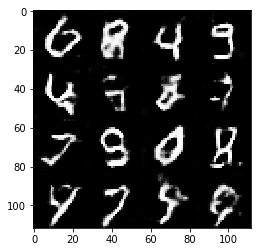

Epoch 1/2... Discriminator Loss: 0.9337... Generator Loss: 0.8976
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.6027
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 1.0339
Epoch 1/2... Discriminator Loss: 0.7034... Generator Loss: 1.7181
Epoch 1/2... Discriminator Loss: 0.9891... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.7454
Epoch 1/2... Discriminator Loss: 0.8505... Generator Loss: 1.6464
Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 2.0090
Epoch 1/2... Discriminator Loss: 3.0046... Generator Loss: 0.1249
Epoch 1/2... Discriminator Loss: 0.7542... Generator Loss: 1.5601


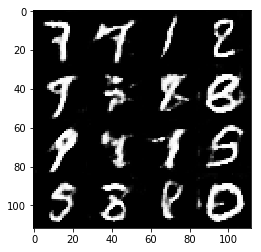

Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 1.1715
Epoch 1/2... Discriminator Loss: 0.9166... Generator Loss: 0.9865
Epoch 1/2... Discriminator Loss: 0.8342... Generator Loss: 1.1417
Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 1.0383
Epoch 1/2... Discriminator Loss: 0.8373... Generator Loss: 1.1107
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.8205
Epoch 1/2... Discriminator Loss: 1.1516... Generator Loss: 0.7257
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 1.6935
Epoch 1/2... Discriminator Loss: 0.8079... Generator Loss: 1.4692
Epoch 1/2... Discriminator Loss: 1.1578... Generator Loss: 0.6356


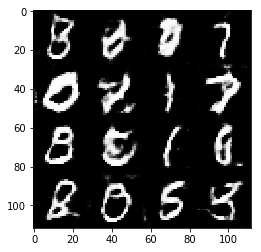

Epoch 1/2... Discriminator Loss: 0.9803... Generator Loss: 2.1532
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.3447
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.5203
Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 0.9220
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 2.1409
Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 0.9338
Epoch 1/2... Discriminator Loss: 1.0023... Generator Loss: 0.9906
Epoch 1/2... Discriminator Loss: 0.8256... Generator Loss: 1.5946
Epoch 1/2... Discriminator Loss: 0.8258... Generator Loss: 1.1588
Epoch 1/2... Discriminator Loss: 1.8381... Generator Loss: 0.4331


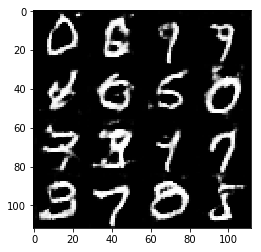

Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.5227
Epoch 1/2... Discriminator Loss: 0.7213... Generator Loss: 1.3467
Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 1.1970
Epoch 1/2... Discriminator Loss: 0.6822... Generator Loss: 1.5500
Epoch 1/2... Discriminator Loss: 0.6976... Generator Loss: 1.5424
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.5873
Epoch 1/2... Discriminator Loss: 0.6099... Generator Loss: 1.8355
Epoch 1/2... Discriminator Loss: 0.8478... Generator Loss: 1.3052
Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 1.8226
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.6026


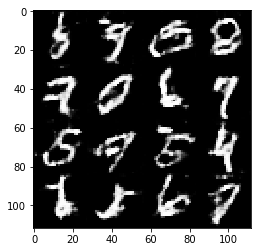

Epoch 1/2... Discriminator Loss: 0.8285... Generator Loss: 1.1421
Epoch 1/2... Discriminator Loss: 0.8056... Generator Loss: 1.4832
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 1.5329
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 1.4683
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 1.6860
Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 1.4507
Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 0.9882
Epoch 1/2... Discriminator Loss: 0.6975... Generator Loss: 1.6820
Epoch 1/2... Discriminator Loss: 0.5745... Generator Loss: 2.2044


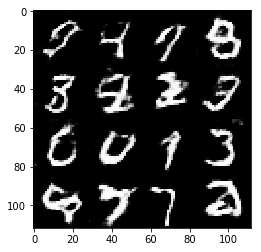

Epoch 1/2... Discriminator Loss: 0.6252... Generator Loss: 1.4020
Epoch 1/2... Discriminator Loss: 1.7301... Generator Loss: 0.3715
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 0.8628... Generator Loss: 1.5811
Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 1.3951
Epoch 1/2... Discriminator Loss: 0.6988... Generator Loss: 1.6624
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 1.0413
Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 1.1805
Epoch 1/2... Discriminator Loss: 0.8402... Generator Loss: 1.2876
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 0.7502


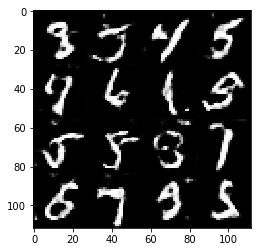

Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.6418
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 1.3624
Epoch 2/2... Discriminator Loss: 0.9820... Generator Loss: 1.1483
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 1.1113
Epoch 2/2... Discriminator Loss: 0.6598... Generator Loss: 1.7967
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 2.0507
Epoch 2/2... Discriminator Loss: 0.7084... Generator Loss: 1.4937
Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 1.3689... Generator Loss: 0.6200
Epoch 2/2... Discriminator Loss: 0.8146... Generator Loss: 1.4393


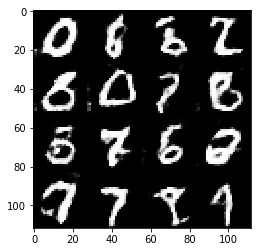

Epoch 2/2... Discriminator Loss: 1.0086... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 0.8631... Generator Loss: 1.1296
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.1766
Epoch 2/2... Discriminator Loss: 1.9209... Generator Loss: 3.7199
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 2.5531
Epoch 2/2... Discriminator Loss: 0.7343... Generator Loss: 1.4344
Epoch 2/2... Discriminator Loss: 1.0022... Generator Loss: 1.5533
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 0.8440
Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 1.1719
Epoch 2/2... Discriminator Loss: 0.7582... Generator Loss: 1.5718


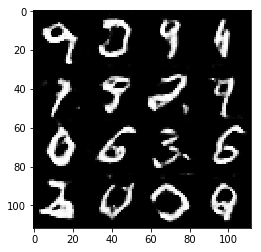

Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 0.9600
Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 1.4344
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 1.0978
Epoch 2/2... Discriminator Loss: 1.1376... Generator Loss: 0.9773
Epoch 2/2... Discriminator Loss: 0.6686... Generator Loss: 1.4758
Epoch 2/2... Discriminator Loss: 0.7174... Generator Loss: 1.8120
Epoch 2/2... Discriminator Loss: 0.6252... Generator Loss: 2.0235
Epoch 2/2... Discriminator Loss: 1.0240... Generator Loss: 0.6649
Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 2.0595
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.7378


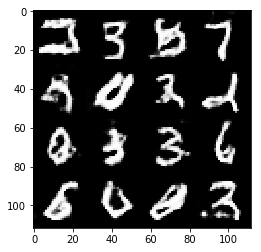

Epoch 2/2... Discriminator Loss: 1.6917... Generator Loss: 0.5783
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 0.9524
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 0.8933
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 1.5433
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 1.7595
Epoch 2/2... Discriminator Loss: 0.7804... Generator Loss: 1.6175
Epoch 2/2... Discriminator Loss: 0.7032... Generator Loss: 1.5938
Epoch 2/2... Discriminator Loss: 0.9798... Generator Loss: 1.1154
Epoch 2/2... Discriminator Loss: 1.1026... Generator Loss: 1.1142
Epoch 2/2... Discriminator Loss: 0.7141... Generator Loss: 1.6915


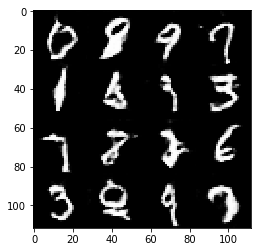

Epoch 2/2... Discriminator Loss: 0.7304... Generator Loss: 1.4848
Epoch 2/2... Discriminator Loss: 0.7175... Generator Loss: 1.3655
Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 1.7303
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.7271
Epoch 2/2... Discriminator Loss: 0.8761... Generator Loss: 2.5036
Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 2.0826
Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 0.9555
Epoch 2/2... Discriminator Loss: 0.7931... Generator Loss: 1.3350
Epoch 2/2... Discriminator Loss: 1.5412... Generator Loss: 0.4365
Epoch 2/2... Discriminator Loss: 0.6450... Generator Loss: 1.7185


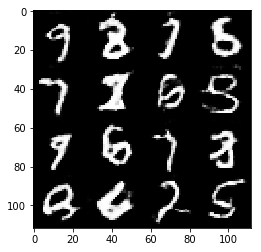

Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 1.4432
Epoch 2/2... Discriminator Loss: 0.8951... Generator Loss: 1.1580
Epoch 2/2... Discriminator Loss: 1.8194... Generator Loss: 0.3247
Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.4872
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 1.9001
Epoch 2/2... Discriminator Loss: 0.6549... Generator Loss: 1.7330
Epoch 2/2... Discriminator Loss: 1.5376... Generator Loss: 2.2763
Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 1.2287
Epoch 2/2... Discriminator Loss: 1.4661... Generator Loss: 0.4841
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.7995


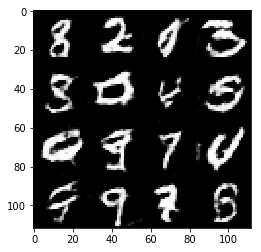

Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 1.0881
Epoch 2/2... Discriminator Loss: 0.6976... Generator Loss: 1.5524
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.1335
Epoch 2/2... Discriminator Loss: 0.8994... Generator Loss: 0.8913
Epoch 2/2... Discriminator Loss: 0.6363... Generator Loss: 1.6903
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.0867
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 0.8458
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.4759
Epoch 2/2... Discriminator Loss: 0.6813... Generator Loss: 1.6017


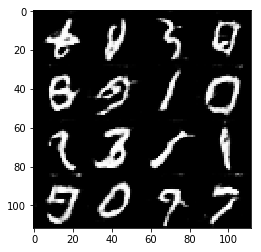

Epoch 2/2... Discriminator Loss: 1.4689... Generator Loss: 2.0985
Epoch 2/2... Discriminator Loss: 0.8123... Generator Loss: 1.5674
Epoch 2/2... Discriminator Loss: 0.6221... Generator Loss: 2.2162
Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 1.8568
Epoch 2/2... Discriminator Loss: 0.7295... Generator Loss: 1.5217
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.7563
Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 1.1307
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 0.8426
Epoch 2/2... Discriminator Loss: 0.8529... Generator Loss: 0.9638
Epoch 2/2... Discriminator Loss: 0.9116... Generator Loss: 1.0376


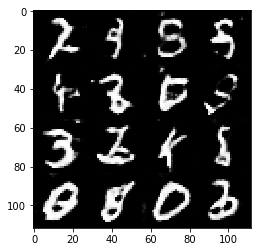

Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 2.4478
Epoch 2/2... Discriminator Loss: 0.5800... Generator Loss: 1.8395
Epoch 2/2... Discriminator Loss: 0.9489... Generator Loss: 0.9916
Epoch 2/2... Discriminator Loss: 0.6816... Generator Loss: 1.9943
Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: 0.6400... Generator Loss: 1.7179
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 1.7062
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 0.6233
Epoch 2/2... Discriminator Loss: 1.6750... Generator Loss: 0.3899
Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 1.0929


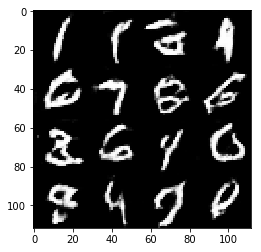

Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.6540
Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.2501
Epoch 2/2... Discriminator Loss: 0.9054... Generator Loss: 1.1893
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 1.9891
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 1.6271
Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 1.1218
Epoch 2/2... Discriminator Loss: 0.5516... Generator Loss: 2.2609
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 1.3190
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 1.5491


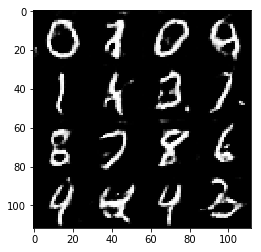

Epoch 2/2... Discriminator Loss: 0.7061... Generator Loss: 1.5860
Epoch 2/2... Discriminator Loss: 0.9522... Generator Loss: 1.7997
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 1.3077
Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 1.0468
Epoch 2/2... Discriminator Loss: 1.0491... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 1.4784
Epoch 2/2... Discriminator Loss: 0.5987... Generator Loss: 1.7928
Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 1.9933
Epoch 2/2... Discriminator Loss: 0.7724... Generator Loss: 1.8206
Epoch 2/2... Discriminator Loss: 0.9754... Generator Loss: 0.9709


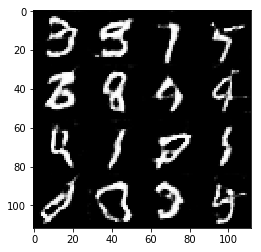

Epoch 2/2... Discriminator Loss: 0.7934... Generator Loss: 1.2374
Epoch 2/2... Discriminator Loss: 0.8331... Generator Loss: 1.5126
Epoch 2/2... Discriminator Loss: 1.5774... Generator Loss: 0.4038
Epoch 2/2... Discriminator Loss: 2.2445... Generator Loss: 0.2998
Epoch 2/2... Discriminator Loss: 0.7824... Generator Loss: 1.3703
Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 1.3807
Epoch 2/2... Discriminator Loss: 0.5408... Generator Loss: 2.1127
Epoch 2/2... Discriminator Loss: 0.8917... Generator Loss: 1.1193
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.1695
Epoch 2/2... Discriminator Loss: 0.6389... Generator Loss: 1.8341


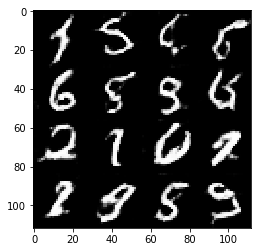

Epoch 2/2... Discriminator Loss: 0.9890... Generator Loss: 1.0356
Epoch 2/2... Discriminator Loss: 0.8328... Generator Loss: 1.4038
Epoch 2/2... Discriminator Loss: 1.2312... Generator Loss: 3.0556
Epoch 2/2... Discriminator Loss: 1.0414... Generator Loss: 0.7729
Epoch 2/2... Discriminator Loss: 0.6908... Generator Loss: 1.8766
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 1.1668
Epoch 2/2... Discriminator Loss: 1.0182... Generator Loss: 2.5675
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 0.8596
Epoch 2/2... Discriminator Loss: 0.6832... Generator Loss: 1.3989
Epoch 2/2... Discriminator Loss: 0.7766... Generator Loss: 1.4868


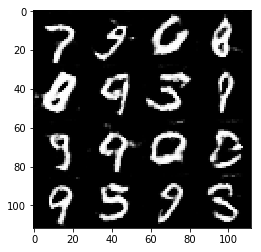

Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 1.5102
Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.6912
Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 1.0299
Epoch 2/2... Discriminator Loss: 0.7984... Generator Loss: 1.4092
Epoch 2/2... Discriminator Loss: 0.7445... Generator Loss: 1.6528
Epoch 2/2... Discriminator Loss: 2.1124... Generator Loss: 0.3025
Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 1.3884
Epoch 2/2... Discriminator Loss: 0.7423... Generator Loss: 1.7511
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.4062
Epoch 2/2... Discriminator Loss: 0.6296... Generator Loss: 2.0397


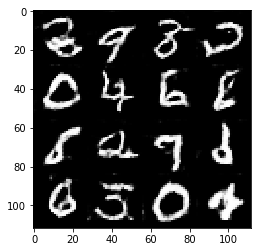

Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 1.9984
Epoch 2/2... Discriminator Loss: 0.7303... Generator Loss: 2.5038
Epoch 2/2... Discriminator Loss: 0.6416... Generator Loss: 1.2790
Epoch 2/2... Discriminator Loss: 0.9972... Generator Loss: 1.0126
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.3149
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 1.0680
Epoch 2/2... Discriminator Loss: 0.6394... Generator Loss: 1.8638
Epoch 2/2... Discriminator Loss: 0.7276... Generator Loss: 1.5019
Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 2.8551
Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 1.8791


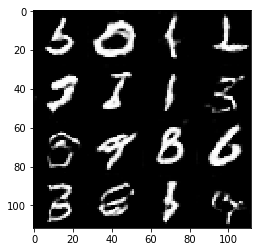

Epoch 2/2... Discriminator Loss: 0.7014... Generator Loss: 2.7481
Epoch 2/2... Discriminator Loss: 0.6173... Generator Loss: 1.4287
Epoch 2/2... Discriminator Loss: 1.4791... Generator Loss: 0.5377
Epoch 2/2... Discriminator Loss: 0.6063... Generator Loss: 1.8859
Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 1.2919
Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 2.1856
Epoch 2/2... Discriminator Loss: 0.9634... Generator Loss: 0.9397
Epoch 2/2... Discriminator Loss: 0.6856... Generator Loss: 1.6997
Epoch 2/2... Discriminator Loss: 0.7232... Generator Loss: 1.4212
Epoch 2/2... Discriminator Loss: 0.6879... Generator Loss: 1.6357


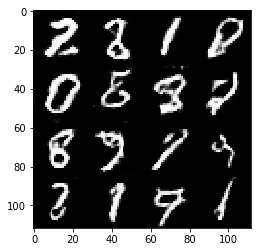

Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.6507
Epoch 2/2... Discriminator Loss: 1.1366... Generator Loss: 2.1110
Epoch 2/2... Discriminator Loss: 0.5867... Generator Loss: 2.1014
Epoch 2/2... Discriminator Loss: 1.7862... Generator Loss: 0.4952
Epoch 2/2... Discriminator Loss: 0.7941... Generator Loss: 1.3972
Epoch 2/2... Discriminator Loss: 0.7013... Generator Loss: 2.3212
Epoch 2/2... Discriminator Loss: 0.5979... Generator Loss: 2.0201
Epoch 2/2... Discriminator Loss: 0.7842... Generator Loss: 2.0221
Epoch 2/2... Discriminator Loss: 0.5956... Generator Loss: 1.8082
Epoch 2/2... Discriminator Loss: 1.0974... Generator Loss: 0.8193


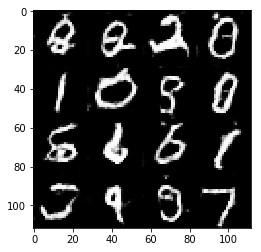

Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.2450
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 0.8227
Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 1.1527
Epoch 2/2... Discriminator Loss: 0.7203... Generator Loss: 1.5798
Epoch 2/2... Discriminator Loss: 0.6507... Generator Loss: 1.8023
Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 1.2266
Epoch 2/2... Discriminator Loss: 0.7002... Generator Loss: 1.7423
Epoch 2/2... Discriminator Loss: 0.6047... Generator Loss: 1.6319
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 1.8270
Epoch 2/2... Discriminator Loss: 0.7532... Generator Loss: 1.1810


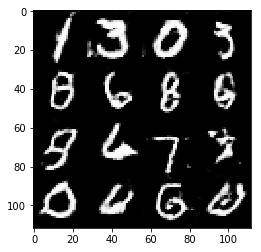

Epoch 2/2... Discriminator Loss: 0.8117... Generator Loss: 2.4642
Epoch 2/2... Discriminator Loss: 0.6453... Generator Loss: 2.2315
Epoch 2/2... Discriminator Loss: 0.6831... Generator Loss: 1.5155
Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 1.4428
Epoch 2/2... Discriminator Loss: 0.6802... Generator Loss: 1.3864
Epoch 2/2... Discriminator Loss: 0.6765... Generator Loss: 1.7950
Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 2.4135
Epoch 2/2... Discriminator Loss: 0.6711... Generator Loss: 2.1005
Epoch 2/2... Discriminator Loss: 0.9837... Generator Loss: 1.1317
Epoch 2/2... Discriminator Loss: 0.7715... Generator Loss: 1.3901


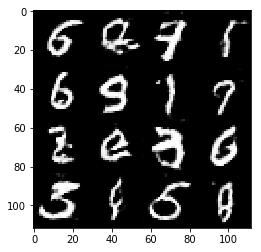

Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 1.2860
Epoch 2/2... Discriminator Loss: 0.7580... Generator Loss: 1.4522
Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 1.3920
Epoch 2/2... Discriminator Loss: 0.6491... Generator Loss: 2.3395
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 1.1944
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 0.9381
Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 2.4573
Epoch 2/2... Discriminator Loss: 0.5664... Generator Loss: 2.0082
Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.7512
Epoch 2/2... Discriminator Loss: 0.5173... Generator Loss: 1.7562


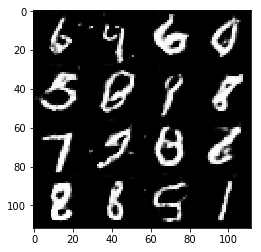

Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 1.2853
Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 1.9554
Epoch 2/2... Discriminator Loss: 0.6006... Generator Loss: 1.8436
Epoch 2/2... Discriminator Loss: 0.5113... Generator Loss: 2.1294
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 2.2147
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 1.5312
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.2475
Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 1.5926
Epoch 2/2... Discriminator Loss: 0.5945... Generator Loss: 2.3866
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.4795


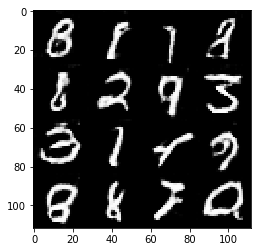

Epoch 2/2... Discriminator Loss: 0.6644... Generator Loss: 1.8049
Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 1.8128
Epoch 2/2... Discriminator Loss: 0.7550... Generator Loss: 1.1187
Epoch 2/2... Discriminator Loss: 0.6100... Generator Loss: 2.1124
Epoch 2/2... Discriminator Loss: 0.4385... Generator Loss: 2.9092
Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 1.3731
Epoch 2/2... Discriminator Loss: 0.6996... Generator Loss: 1.5698
Epoch 2/2... Discriminator Loss: 0.6612... Generator Loss: 2.5360
Epoch 2/2... Discriminator Loss: 0.8995... Generator Loss: 1.1869
Epoch 2/2... Discriminator Loss: 0.5888... Generator Loss: 2.4543


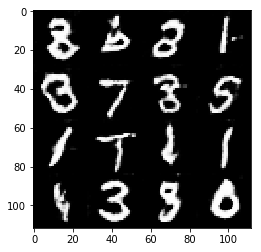

Epoch 2/2... Discriminator Loss: 1.6807... Generator Loss: 0.3375
Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 1.8968
Epoch 2/2... Discriminator Loss: 0.7467... Generator Loss: 1.7088
Epoch 2/2... Discriminator Loss: 0.5989... Generator Loss: 1.8099
Epoch 2/2... Discriminator Loss: 0.6284... Generator Loss: 2.1160
Epoch 2/2... Discriminator Loss: 0.9705... Generator Loss: 0.9484
Epoch 2/2... Discriminator Loss: 0.9005... Generator Loss: 1.1650
Epoch 2/2... Discriminator Loss: 0.6015... Generator Loss: 2.3999
Epoch 2/2... Discriminator Loss: 0.7059... Generator Loss: 2.4070
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 1.9995


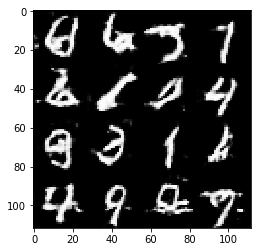

Epoch 2/2... Discriminator Loss: 0.6060... Generator Loss: 2.6022
Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 0.9870
Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 1.4479
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 1.9240
Epoch 2/2... Discriminator Loss: 0.7567... Generator Loss: 1.0510
Epoch 2/2... Discriminator Loss: 1.1586... Generator Loss: 0.9007
Epoch 2/2... Discriminator Loss: 0.7139... Generator Loss: 1.4862
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 0.5471... Generator Loss: 2.0358
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 2.2196


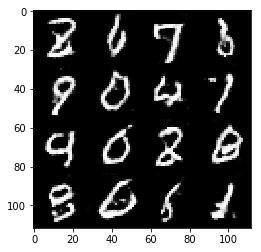

Epoch 2/2... Discriminator Loss: 0.6042... Generator Loss: 1.6486
Epoch 2/2... Discriminator Loss: 1.1220... Generator Loss: 0.9955
Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 2.4483
Epoch 2/2... Discriminator Loss: 1.1319... Generator Loss: 0.9645
Epoch 2/2... Discriminator Loss: 0.5501... Generator Loss: 2.3528
Epoch 2/2... Discriminator Loss: 0.5508... Generator Loss: 2.0506
Epoch 2/2... Discriminator Loss: 0.9626... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.2503
Epoch 2/2... Discriminator Loss: 0.6542... Generator Loss: 1.7512
Epoch 2/2... Discriminator Loss: 0.6055... Generator Loss: 1.9122


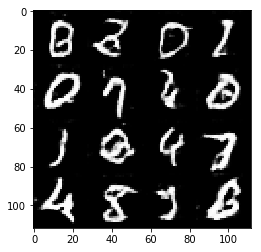

In [13]:
batch_size = 24
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


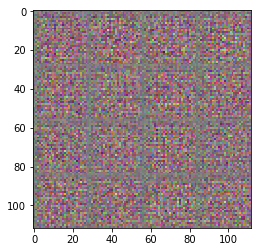

Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 2.7227
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 4.9841
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.7215
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 2.1889
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.5165
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 1.9237
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 2.6832
Epoch 1/1... Discriminator Loss: 0.4814... Generator Loss: 2.3037
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 2.5123


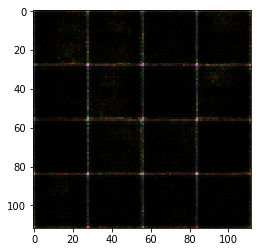

Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 2.2380
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.6637
Epoch 1/1... Discriminator Loss: 0.4340... Generator Loss: 3.2122
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 4.2192
Epoch 1/1... Discriminator Loss: 0.4574... Generator Loss: 2.7917
Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 3.5005
Epoch 1/1... Discriminator Loss: 0.4431... Generator Loss: 2.6855
Epoch 1/1... Discriminator Loss: 0.6457... Generator Loss: 1.9608
Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 3.6500
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 6.9098


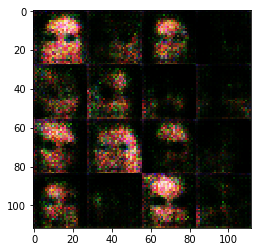

Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 3.3681
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 0.4247... Generator Loss: 3.5083
Epoch 1/1... Discriminator Loss: 0.3814... Generator Loss: 4.3282
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 3.7944
Epoch 1/1... Discriminator Loss: 0.3605... Generator Loss: 4.7282
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 3.2370
Epoch 1/1... Discriminator Loss: 0.3651... Generator Loss: 5.4021
Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 3.3073
Epoch 1/1... Discriminator Loss: 0.4814... Generator Loss: 2.8377


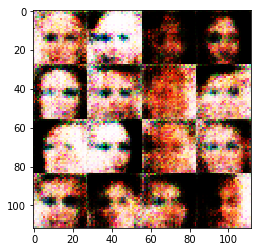

Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 3.1321
Epoch 1/1... Discriminator Loss: 0.3746... Generator Loss: 3.8869
Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 2.7186
Epoch 1/1... Discriminator Loss: 0.3797... Generator Loss: 4.3117
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.3001
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 4.2308
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 2.4532
Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 3.6658
Epoch 1/1... Discriminator Loss: 0.4596... Generator Loss: 2.6907
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 3.2142


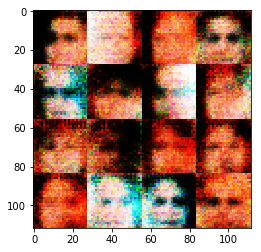

Epoch 1/1... Discriminator Loss: 0.4412... Generator Loss: 4.1624
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 5.1054
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 2.1883
Epoch 1/1... Discriminator Loss: 0.5394... Generator Loss: 3.5014
Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 2.8831
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 2.3801
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 2.3841
Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 1.6570
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 2.9850
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 2.0625


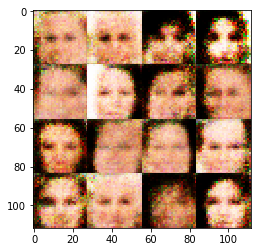

Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 2.1187
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 3.4355
Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 2.7322
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 2.2858
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 1.6821
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 4.0248
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 2.9382
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 3.5426
Epoch 1/1... Discriminator Loss: 0.4913... Generator Loss: 2.4834


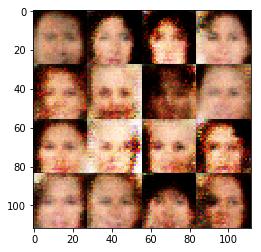

Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 2.1665
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 2.5569
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 2.6385
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 1.7308
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 2.5717
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 2.5975
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 2.4404
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 2.8381
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.7022


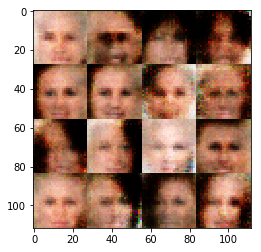

Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 2.3474
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 1.6869
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 2.3660
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 2.6903
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 2.9385
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.4465
Epoch 1/1... Discriminator Loss: 1.9145... Generator Loss: 0.2869
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.1307


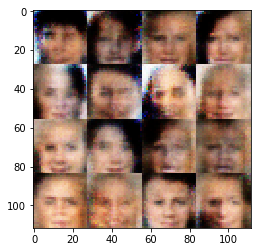

Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 2.1846
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 2.6549
Epoch 1/1... Discriminator Loss: 1.6975... Generator Loss: 4.5188
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.5317
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 2.3511
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 1.7663


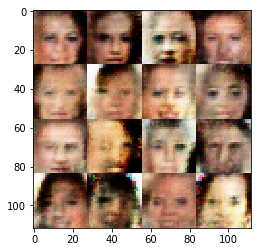

Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.8157
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.5842
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.6514
Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 1.9235
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 1.6672
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 1.3712
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.8689
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.3627


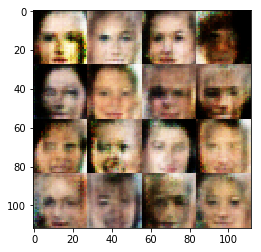

Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.7166
Epoch 1/1... Discriminator Loss: 2.7795... Generator Loss: 4.7798
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 2.3501
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.2512
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 2.2165
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 2.1925
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 2.2339
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 2.0061


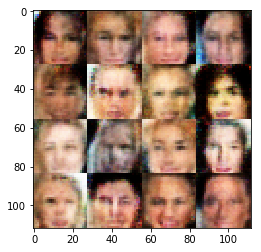

Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.2949
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 2.3962
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 1.5112
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 2.7670
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 3.4855
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.0117


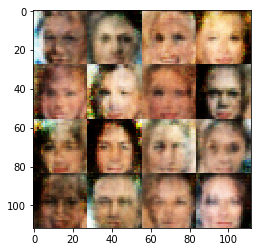

Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 1.4593
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.7697
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.9583
Epoch 1/1... Discriminator Loss: 0.7448... Generator Loss: 1.7337
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.9140


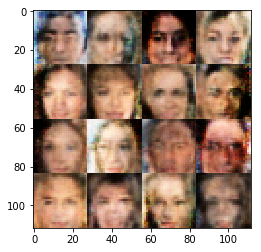

Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 2.3287
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 2.7741
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.5159
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.1926
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.8059


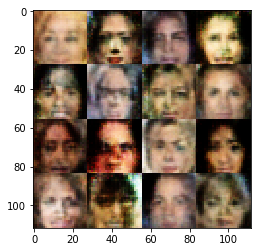

Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 2.9840
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.6907
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.5262
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.4135
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.4130
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 1.6743
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.3923


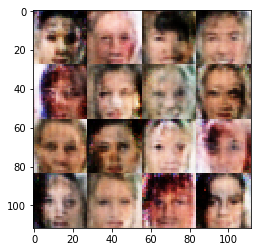

Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 1.5929
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.4072
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.8023
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.4857
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 1.4599


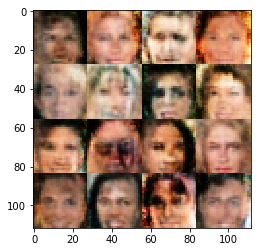

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 2.1650
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.1979
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 2.0569... Generator Loss: 2.5906
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 1.3509


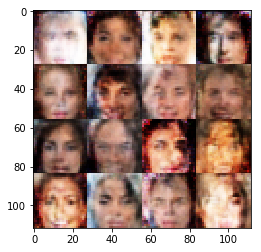

Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.5439
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.5116
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 1.2913
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.8803


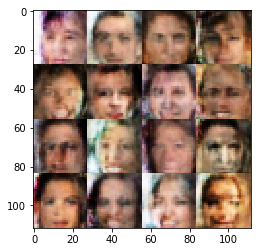

Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.6224... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 3.6002
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8181


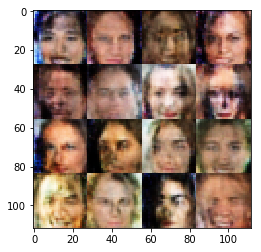

Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 1.8625
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.2980
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.7436
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.8210
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 2.6235


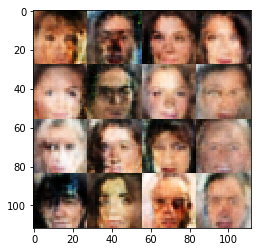

Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.7451
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.4083
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.4570
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.2736
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.5776
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.4704


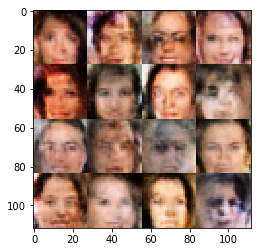

Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.3472
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.7608... Generator Loss: 0.4157
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 2.4716
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.1644
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.2322


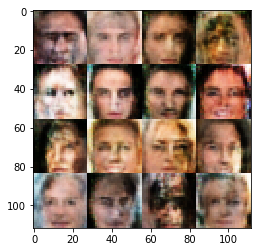

Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.8349
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.2525
Epoch 1/1... Discriminator Loss: 2.0400... Generator Loss: 0.2870
Epoch 1/1... Discriminator Loss: 1.7044... Generator Loss: 0.3737
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 1.7906
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.6788... Generator Loss: 0.3754
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.7468


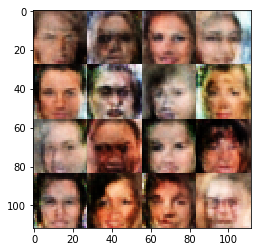

Epoch 1/1... Discriminator Loss: 1.6474... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.7256
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.4491
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.6783
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.5753
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 1.3115


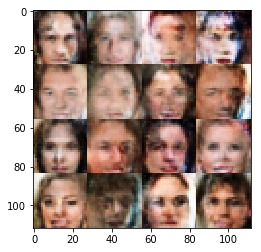

Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.6110... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.5318
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.5781
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 0.8063


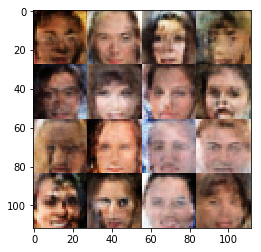

Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.4986
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.5977


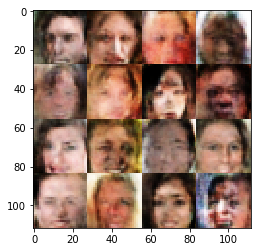

Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.3050
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.4664
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.8041


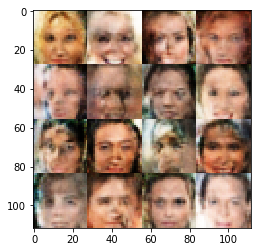

Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 1.6859
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.3526


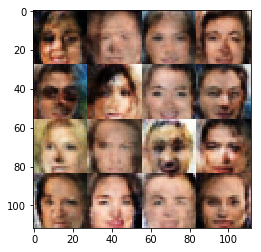

Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.5975... Generator Loss: 0.4641
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.4200
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.6162
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.4679


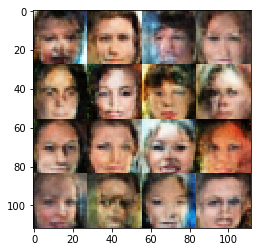

Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.7140
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.6250


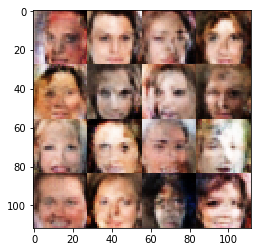

Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 2.3733... Generator Loss: 0.2217
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.5102
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.0073


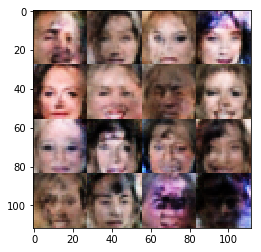

Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.0701


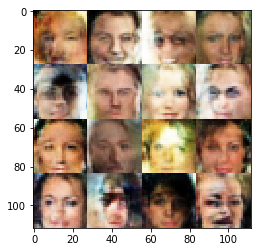

Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.0977


In [ ]:
batch_size = 24
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.